Question 1 : Quelles sont selon vous, les principales différences entre l'exécution du code sur Google Colab et l'installation locale d'un environement Python ?

Réponse :


---




**Google Colab** EST un environnement en ligne prêt à l’emploi pour l’exécution de code Python avec un acc'es gratuits aux GPU/TPU et aux bibliothèques préinstallées comme TensorFlow et PyTorch. Il facilite l’expérimentation et la collaboration, car les notebooks sont automatiquement sauvegardés sur Google Drive et peuvent être partagés. Une personne ne disposant pas d'un ordinateur avec de très grandes performances ou qui débute, ou qui ne maitrise pas forcément l'installation des dépendances et tout peut l'utiliser facilement, sans avoir à se soucier de ces détails. L'autre avantage de colab que j'apprecie c'Est le fait de pouvoir compiler séparement les bouts de codes. Cela permet de détecter facilement les endroits à problèmes.

Toutefois, Colab présente des limitations comme, des sessions de temps limité et une dépendance à la connexion internet. Pour la realisation de ce TP j'ai du attendre plusieurs fois le lendemain pour pouvoir le continuer faute de la limite journalière.

Quant à l’exécution locale d’un environnement **Python**, il offre un contrôle total sur la configuration et l’installation des bibliothèques. Je le trouve idéal pour ceux qui savent ce qu'ils font ou qui veulent apprendre à le faire eu même. Donc Les utilisateurs ne sont pas contraints par des limites de temps ou de ressources imposées par une plateforme externe. Par contre, configurer un environnement local nécessite du matériel puissant et une installation manuelle des dépendances, ce qui peut être complexe pour les débutants.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
 # On récupère les images d'entraînement (28x28 pixels en niveaux de gris) dans␣la variable train_images
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
 # On redimensionne les images en 28x28 avec un seule couche pour la couleur (un␣ niveau de gris)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images- 127.5) / 127.5
 # Normalisation de la couleur des images entre-1 et 1 (plutôt que 0-255)
 # Buffer = nombre total d'images
 # Batch = nombre d'images traitées à chaque entrainement du modèle
BUFFER_SIZE = 60000

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


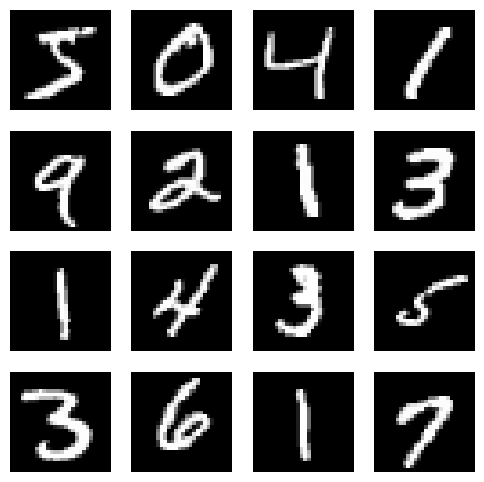

In [3]:
BATCH_SIZE = 256

# Visualiser 16 images
def show_images(images):
    # Crée une grille de 4x4 images avec une taille de figure définie
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))

    # Parcourt les axes pour afficher les images
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')  # Supprime les axes pour un meilleur rendu visuel

    plt.show()

# Afficher 16 images aléatoires du dataset
show_images(train_images[:16])


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
def make_generator_model():
 model = tf.keras.Sequential()
 model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
 model.add(layers.BatchNormalization())
 model.add(layers.LeakyReLU())
 model.add(layers.Reshape((7, 7, 256)))
 model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
 padding='same', use_bias=False))
 model.add(layers.BatchNormalization())
 model.add(layers.LeakyReLU())
 model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
 padding='same', use_bias=False))
 model.add(layers.BatchNormalization())
 model.add(layers.LeakyReLU())
 model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
 use_bias=False, activation='tanh'))
 return model

In [ ]:
def make_discriminator_model():
 model = tf.keras.Sequential()
 model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
 input_shape=[28, 28, 1]))
 model.add(layers.LeakyReLU())
 model.add(layers.Dropout(0.3))
 model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
 model.add(layers.LeakyReLU())
 model.add(layers.Dropout(0.3))
 model.add(layers.Flatten())
 model.add(layers.Dense(1))
 return model

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Fonction de perte pour le discriminateur
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss  # Cette ligne doit être indentée correctement

# Fonction de perte pour le générateur
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
def generate_and_show_images(model, epoch, test_input):
 print("Entrainement "+ str(epoch))
 predictions = model(test_input, training=False)
 fig = plt.figure(figsize=(4, 4))
 for i in range(predictions.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.show()
 print("-------------------")

In [12]:
@tf.function
def train_step(images):
    # Génération de bruit aléatoire pour le générateur
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Enregistrement des gradients pour le générateur et le discriminateur
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Générer des images avec le générateur
        generated_images = generator(noise, training=True)

        # Calcul des sorties du discriminateur pour les vraies et fausses images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calcul des pertes
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calcul des gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Application des gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Optionnel : générer et afficher des images après chaque époque
        generate_and_show_images(generator, epoch + 1, seed)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entrainement 1


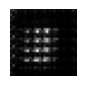

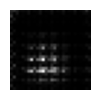

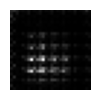

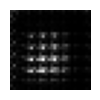

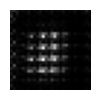

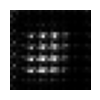

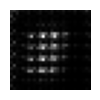

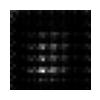

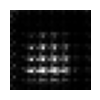

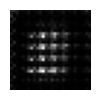

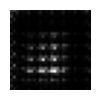

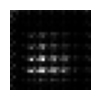

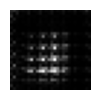

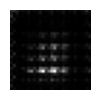

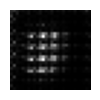

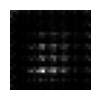

-------------------
Entrainement 2


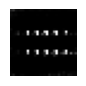

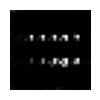

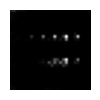

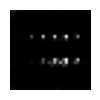

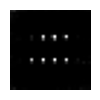

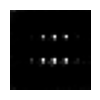

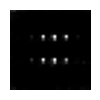

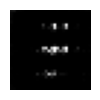

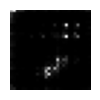

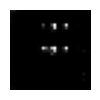

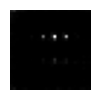

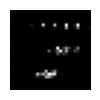

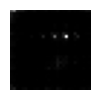

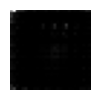

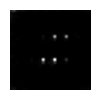

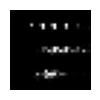

-------------------
Entrainement 3


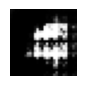

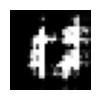

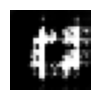

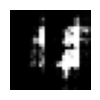

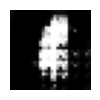

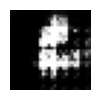

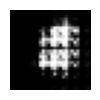

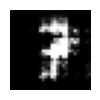

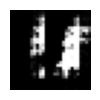

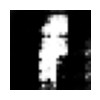

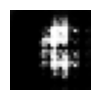

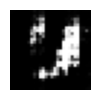

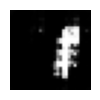

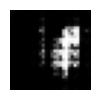

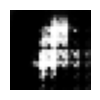

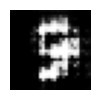

-------------------
Entrainement 4


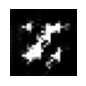

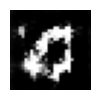

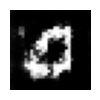

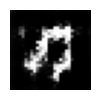

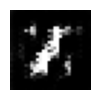

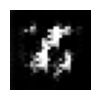

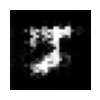

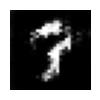

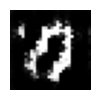

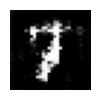

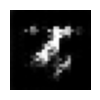

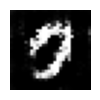

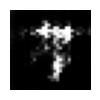

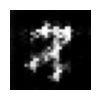

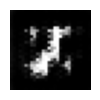

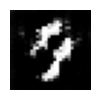

-------------------
Entrainement 5


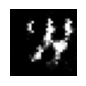

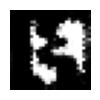

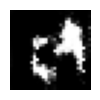

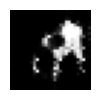

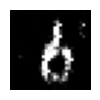

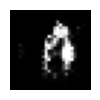

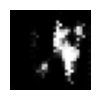

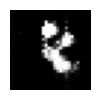

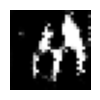

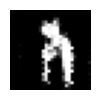

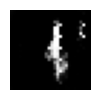

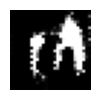

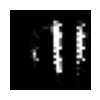

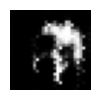

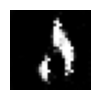

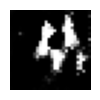

-------------------
Entrainement 6


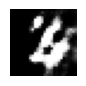

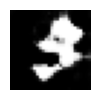

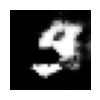

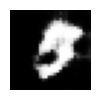

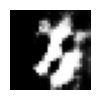

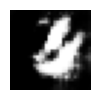

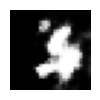

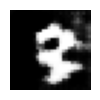

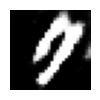

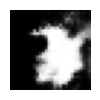

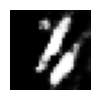

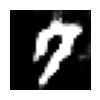

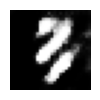

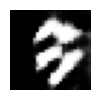

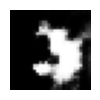

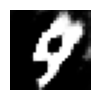

-------------------
Entrainement 7


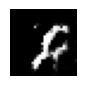

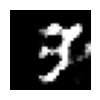

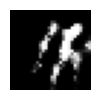

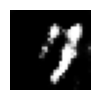

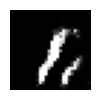

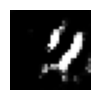

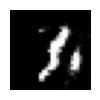

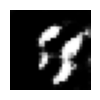

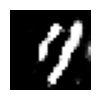

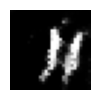

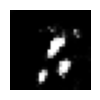

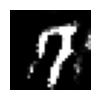

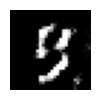

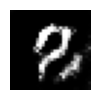

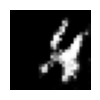

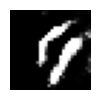

-------------------
Entrainement 8


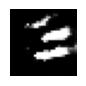

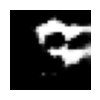

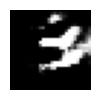

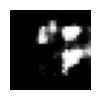

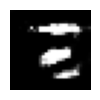

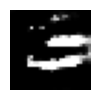

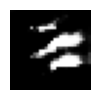

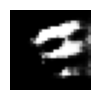

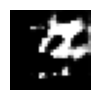

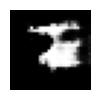

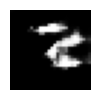

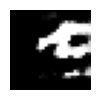

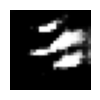

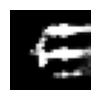

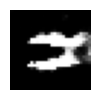

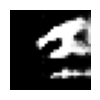

-------------------
Entrainement 9


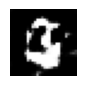

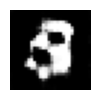

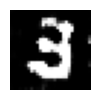

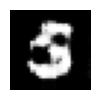

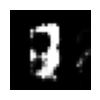

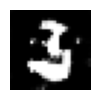

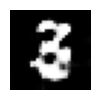

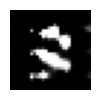

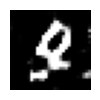

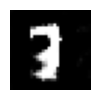

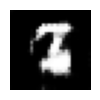

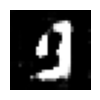

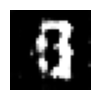

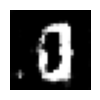

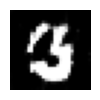

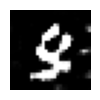

-------------------
Entrainement 10


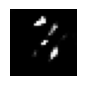

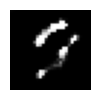

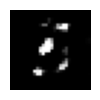

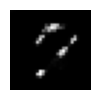

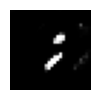

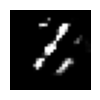

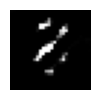

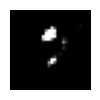

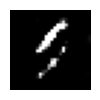

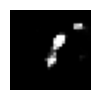

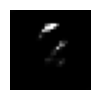

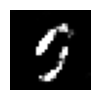

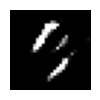

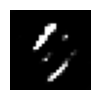

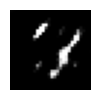

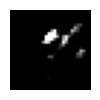

-------------------


In [13]:
generator = make_generator_model()
discriminator = make_discriminator_model()
train(train_dataset, EPOCHS)

Question 2 :
Pourquoi le modèle discriminatif d’un GAN est-il aussi important que le génératif ? Expliquez la relation entre les deux composants du GAN et comment ils interagissent pour améliorer la qualité *des* images générées.

RÉPONSE :


---



Les deux modèles sont complémentaires

Le modèle discriminatif est aussi important que le génératif, car ils fonctionnent en ensemble pour améliorer la qualité des images. Le générateur produit des images à partir de bruit aléatoire, alors que le discriminateur évalue ces images pour distinguer les fausses des vraies. Cette relation crée une compétition entre les deux modele faisant que le générateur tente de tromper le discriminateur, et le discriminateur s’efforce de mieux détecter les faux. Ça améliore progressivement la qualité et le realisme des images générées.

Question 3 :
Quels sont les principaux défis auxquels un GAN fait face lors de l’entraînement ?

REPONSE:

---



Les GANs peuvent rencontrer plusieurs défis lors de l’entraînement. il peut être difficile d’équilibrer le générateur et le discriminateur : si l’un est trop performant par rapport à l’autre, le modèle ne progresse pas correctement.

Dnas la suite de l'exercice lorsque j'ai essayé de changer les paramètres je ne savais pas comment équilibrer les données, ce qui a fait que des images qui se formainet bien déjà se sont détériorées. Donc c'est un véritable problème de ne pas savoir trouver le juste milieu entre les données.


Aussi, le problème du mode collapse peut apparaître, où le générateur produit des images limitées et répétitives, sans diversité comme dans le cas actuel. il y a aussi que, l’entraînement est souvent long; je l'ai par exemple ramené à 10 epoques à un moment pour pouvoir evoluer.

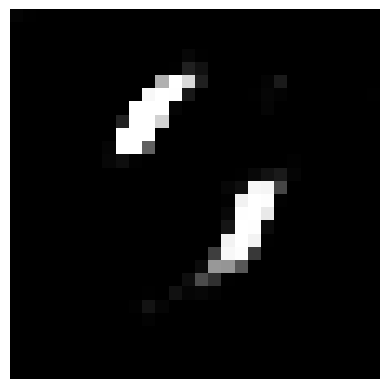

In [14]:
# Créer un bruit aléatoire
noise = tf.random.normal([1, 100])
 # Générer une image à partir du bruit
generated_image = generator(noise, training=False)
 # On redimensionne l'image pour la visualiser correctement
 # Affichage de l'image générée
generated_image = (generated_image[0, :, :, 0] * 127.5 + 127.5).numpy().astype(np.uint8)
plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()

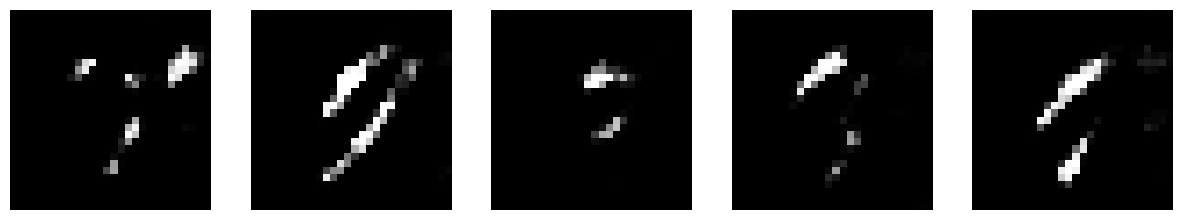

In [15]:
# Nombre d'images à générer
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

for i in range(num_images):
    noise = tf.random.normal([1, 100])  # Génération de bruit aléatoire
    generated_image = generator(noise, training=False)  # Image générée par le générateur

    # Transformation pour l'affichage (ramener les valeurs entre 0 et 255)
    generated_image = (generated_image[0, :, :, 0] * 127.5 + 127.5).numpy().astype(np.uint8)

    # Affichage de l'image
    axes[i].imshow(generated_image, cmap='gray')
    axes[i].axis('off')

plt.show()


Question 4: Comment pourriez vous evaluer objectivement la qualité de siamges générées par un GAN ? Il y a t-il des métriques ou des criteres spécifiques que vous pourriez utiliser, autre que la méthode FID que vous allez tester ?

REPONSE :

---





pour évaluer objectivement la qualité des images générées par un GAN, plusieurs métriques peuvent être utilisées. En complément du score FID, le Score Inception (IS) est une option courante. Il mesure la qualité en évaluant si les images générées appartiennent clairement à des catégories spécifiques, tout en vérifiant la diversité des catégories produites. Une autre approche est l'utilisation de la similarité perceptuelle, comme la métrique LPIPS, qui compare les caractéristiques visuelles des images générées à celles des vraies images. Des méthodes comme le SSIM (Structural Similarity Index) ou le PSNR (Peak Signal-to-Noise Ratio) peuvent aussi être appliquées pour mesurer la qualité en comparant directement les structures et détails des images. Il y a aussi (naturellement), l'évaluation visuelle par des humains ou une analyse de la diversité des images générées peut être envisagée pour détecter des problèmes comme le mode collapse.


En combinant plusieurs de ces approches, il est possible de mieux évaluer la qualité des images produites par le GAN.

 Question 5:
 Expérimentez avec différents paramètres d’entraînement (par exemple, le taux d’apprentissage ou le batch size). Quelles différences observez-vous sur les images générées ? Essayez d’expliquer pourquoi certains paramètres donnent de meilleurs résultats que d’autres.

 REPONSE :


---



Lorsque je modifie le taux d'apprentissage en utilisant ces paramètres '' generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)', les images qui devenaient deja nettes redeviennent totalement floues et pas précises.

Avec un BATCH_SIZE = 64, le modèle était plus précis, mais le générateur produisait parfois des images incohérentes.
Avec une grande taille de lot (BATCH_SIZE = 512), l'entraînement est plus stable, mais les images se ressemblent toutes.
Je trouve que la taille intermediaire (BATCH_SIZE = 256) est un bon compromis produisant des images stables et détaillées tout en maintenant une bonne diversité.

Certains paramètres donnent de meilleurs résultats car ils influencent directement la stabilité et l’efficacité de l’entraînement. Par exemple, un taux d’apprentissage trop élevé entraîne des ajustements trop rapides, ce qui rend l’apprentissage instable et les images générées incohérentes, tandis qu’un taux trop faible ralentit l’amélioration du modèle. iL FAUT TROUVER LE BON MILIEU !

In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
inception_model = InceptionV3(include_top=False, pooling='avg',input_shape=(299, 299, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
from scipy import linalg
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_image(image):
    # Convertir une image en niveaux de gris en image RGB
    image = tf.image.grayscale_to_rgb(image)
    # Redimensionner l'image à 299x299 pixels
    image = tf.image.resize(image, (299, 299))
    # Appliquer le prétraitement pour le modèle InceptionV3
    image = preprocess_input(image)
    return image


In [18]:
# Fonction pour extraire les caractéristiques des images
def get_features(images, model):
    # Prétraitement des images
    preprocessed_images = preprocess_image(images)
    # Passage des images dans le modèle pour extraire les caractéristiques
    features = model(preprocessed_images)
    return features.numpy()

# Exemple : préparation de l'image générée
# Ajouter une dimension batch pour correspondre au format attendu par le modèle
generated_image = tf.expand_dims(generated_image, 0)
# Ajouter une dimension couleur (convertir en 3 canaux si nécessaire)
generated_image = tf.expand_dims(generated_image, 3)

# Extraction des caractéristiques pour l'image générée
gen_features = get_features(generated_image, inception_model)


In [19]:
# Même chose pour les images réelles. On utilise la première image du dataset␣ plutôt que l'ensemble des images
real_image = train_images[0]
real_image = tf.expand_dims(real_image, 0)
real_features = get_features(real_image, inception_model)

In [20]:
from scipy import linalg
import numpy as np

# Fonction pour calculer le score FID
def calculate_fid(real_features, gen_features):
    # Moyennes et matrices de covariance des vraies et fausses images
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Calcul de la distance entre les moyennes
    diff = mu1 - mu2

    # Calcul du score FID
    covmean = linalg.sqrtm(sigma1.dot(sigma2))  # Racine carrée matricielle
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Éliminer les parties imaginaires résultant de petites erreurs numériques

    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [21]:
# Simuler les caractéristiques des vraies images pour tester
real_features = np.random.rand(100, 2048)  # 100 vraies images avec 2048 caractéristiques

# Génération et évaluation des images
generated_images = [tf.random.normal([1, 100]) for _ in range(10)]
generated_images = [generator(noise, training=False) for noise in generated_images]
generated_images = tf.concat(generated_images, axis=0)

gen_features = get_features(generated_images, inception_model)

fid_score = calculate_fid(real_features, gen_features)
print(f"FID Score des images générées : {fid_score.real}")


FID Score des images générées : 677.7023401353911


Question 6:
 Que concluez-vous vis-à-vis du score FID obtenu ?
 Quelles améliorations pourriez-vous apporter au modèle ? Proposez des modifications possibles pour
 améliorer la génération des images (par exemple, ajustement des hyperparamètres, architecture
 modifiée, dataset plus vaste)

 REPONSE :

---



Le score FID  obtenu au dernier entrainement estde 677.7023401353911 (tout en insdiquant qu'au début il avoisinnait 690). Ce score est élevé. Ce qui signifie que les images générées par le modèle sont très différentes des vraies images, ce qui est totalement vrai par rapport aux résulats otenus. Ça signifie que le générateur n'a pas encore appris à produire des images réalistes et a besion d'ajustement et de plus d'entrainement pour s'améliorer.

Comme amélioration on peut modifier le taux d'apprentissage à 1e-3 ( pour apprendr eplus rapidement) ou 1e-5 ( pour avoir plus de stabilité) par exemple (je me dis que c'est logique) et augmenter le batch_size à 512.

On peut aussi utiliser plus de données pour aider le modèle à capturer plus de diversités d'exemples

Augmenter le nombre d'époque est egalement un moyen de donner au modèle plus de temps d'Apprentissage.



Question 7 :
 Comparez le GAN utilisé dans ce TP à d’autres types de réseaux génératifs, comme les Variational Autoencoders (VAE). Quelles sont les différences principales en termes d’architecture et
 d’application ?

 REPONSE :


---



Les GANs sont meilleurs pour générer des données très réalistes, mais leur entraînement est complexe. Les VAEs sont plus simples à entraîner mais sont mieux adaptés aux tâches nécessitant une représentation explicite et contrôlée des données.

Question 8 :
 En dehors de la génération d’images, dans quels autres domaines les GANs sont-ils utilisés au
jourd’hui ? Pouvez-vous imaginer d’autres applications potentielles ?

REPONSE :


---



Les GANs sont  utilisés dans divers domaines aujoudhui à cause de leur capacité à générer des contenus réalistes. Dans l’audio et la vidéo, ils permettent de créer des voix synthétiques, de la musique, ou des vidéos réalistes comme les deepfakes. En médecine, ils servent à produire des images synthétiques, comme des radiographies, pour entraîner des modèles sans toutefois compromettre la confidentialité des données. Ils sont aussi utilisé s  pour améliorer les images, en augmentant leur résolution ou en colorisant des photos en noir et blanc, chose pratique pour les graphistes etc. Dans le domaine artistique, ils génèrent des œuvres uniques ou des designs pour des produits. (Sur ce point je me pose quand même une question : quel sera l'avenir de l'art ? )

 À l’avenir, je me dis qu'ils pourraient être utilisés pour la simulation d’environnements complexes en éducation, la surveillance environnementale avec des images satellites, ou encore la recherche scientifique en faiant des simulations ou des choses comme ça.